In [40]:
import polars as pl
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture


In [41]:
np.random.seed(0)

In [42]:
df = pl.read_csv("CRC01_single_cell_table.csv")
df = df.to_pandas()

# subset for faster computation when debugging
#df = df.iloc[:5000, ]
#df

In [57]:
cols = df.columns
marker_cols = cols[1: -9]
coord_cols = cols[-9: -7]
# remove certain elements
marker_cols = [mc for mc in marker_cols if mc not in ["Hoechst", "Argo550", "AF1"]]
marker_cols

['CD31',
 'CD45',
 'CD68',
 'CD4',
 'FOXP3',
 'CD8a',
 'CD45RO',
 'CD20',
 'PD-L1',
 'CD3e',
 'CD163',
 'E-cadherin',
 'PD-1',
 'Ki67',
 'Pan-CK',
 'SMA']

In [52]:
adata = sc.read("temp_adata.h5ad")
adata

/opt/miniconda3/envs/Summer2025/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1620375 × 16
    obs: 'CellID', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'leiden_clusters'
    var: 'mean', 'std'
    uns: 'leiden_clusters', 'leiden_clusters_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'log1p', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

In [95]:
# Dominant markers
top_genes =  pd.DataFrame(adata.uns["rank_genes_groups"]["names"])
print(top_genes.iloc[0:3, ])

            0      1      2      3      4     5     6     7     8      9  ...  \
0      Pan-CK   CD31  CD163    SMA  PD-L1   SMA   CD4  CD8a  CD20   CD68  ...   
1       CD163  CD163    SMA  CD163   CD20  CD31  CD45  CD3e  CD45  CD163  ...   
2  E-cadherin    SMA   CD45   CD31    SMA   CD4  CD3e  CD45  CD31    CD4  ...   

       11          12          13          14          15          16    17  \
0   PD-L1      Pan-CK      Pan-CK      Pan-CK  E-cadherin        Ki67  Ki67   
1    CD20  E-cadherin  E-cadherin  E-cadherin        Ki67  E-cadherin  PD-1   
2  CD45RO        CD8a        Ki67        Ki67        PD-1        PD-1  CD20   

           18     19     20  
0        CD20  PD-L1    CD4  
1  E-cadherin  FOXP3  PD-L1  
2      Pan-CK   CD20  FOXP3  

[3 rows x 21 columns]


In [84]:
# extract exprs data from adata for further analysis
gene_df = sc.get.obs_df(adata, keys=["leiden_clusters", *marker_cols])
# convert to pandas
gene_df = pl.DataFrame(gene_df)
gene_df


leiden_clusters,CD31,CD45,CD68,CD4,FOXP3,CD8a,CD45RO,CD20,PD-L1,CD3e,CD163,E-cadherin,PD-1,Ki67,Pan-CK,SMA
cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0""",-0.556207,-0.540815,-0.480171,-0.733641,-0.595304,-0.54454,-2.140197,-0.712167,-1.850492,-0.931429,-0.265846,-0.922795,-1.488486,-0.654615,-0.848747,-0.594724
"""1""",2.499437,0.007949,-0.373668,-0.188009,0.746363,0.160836,-0.057212,1.649209,0.075837,-0.422012,-0.182821,-0.852734,-1.336224,-0.625078,-0.856469,-0.366507
"""4""",-0.158286,-0.588984,-0.618306,-1.012596,-0.632458,-0.523647,-2.377256,-0.707261,-1.994702,-0.971544,-0.418985,-0.930318,-1.727947,-0.671324,-0.853393,-0.564455
"""5""",0.180737,-0.539934,-0.48784,-0.037253,-0.233485,-0.342784,-1.096966,-0.370084,-1.049234,-0.651899,-0.183911,-0.906881,-1.22947,-0.586233,-0.993286,10.399103
"""5""",0.045433,-0.5195,-0.445452,-0.108752,-0.202792,-0.309482,-0.987952,-0.304166,-0.803446,-0.5679,-0.144325,-0.898147,-1.038596,-0.562329,-0.952062,7.46777
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""10""",-0.998272,-0.399482,-0.644334,-1.354013,0.021191,-0.330093,-1.926376,-2.502209,-2.561982,-1.72657,0.962086,-1.331132,-0.652609,-0.985774,-0.515843,-1.58076
"""10""",-0.916433,-0.533909,-0.639261,-1.557495,0.045208,-0.290332,-1.768292,-2.367272,-2.471242,-1.779485,0.861666,-1.316391,-0.557771,-0.992026,-0.52479,-1.364717
"""10""",-0.986209,-0.544336,-0.659428,-1.394802,0.054706,-0.292513,-1.797471,-2.484632,-2.433621,-1.752095,0.935798,-1.330958,-0.536778,-1.002393,-0.519558,-1.271408


In [88]:
# print number of cells in each cluster
for i in range(0, 21):
    temp = gene_df.filter(pl.col("leiden_clusters").cast(pl.Int32)==i).shape[0]
    print(temp)


    


30029
63634
282400
85949
8175
3828
83229
64618
14566
101638
55655
41197
88482
145517
243602
196318
37570
73172
417
276
103


In [122]:
# function to add annotations by GMM stratification to obs labels

def stratify_by_marker(ann_data_obj, marker_name, gmm_components):
    log_exprs = ann_data_obj[:, marker_name].layers["log1p"].flatten()

    gmm = GaussianMixture(n_components=gmm_components, random_state=0)
    gmm.fit(log_exprs.reshape(-1, 1))

    labs = gmm.predict(log_exprs.reshape(-1, 1))
    ann_data_obj.obs[f"{marker_name}_strat"] = labs

# function to display bar plot by marker stratification

def plot_strat(df, marker_name):
    plt.figure(figsize=(10, 6))
    df[f"{marker_name}_strat"] = adata.obs[f"{marker_name}_strat"]
    df.groupby("leiden_clusters")[f"{marker_name}_strat"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
    plt.title(f"{marker_name} Stratification")
    plt.xlabel("Clusters")
    plt.ylabel("Prop")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# function to print for each cluster, how many cells are marked as positive for a given marker
# add specifications for if input is list of markers, and if the specification is OR or AND

def print_counts(df, num_clusters, markers_and_operator):
    markers = markers_and_operator[0]
    operator = markers_and_operator[1] if len(markers_and_operator) > 1 else "NONE"
    for i in range(0, num_clusters):
        #if isinstance(markers, list):
        ident = [m + "_strat" for m in markers] # match to column names in adata.obs
        if operator == "OR":
            # count the cells that are positive (have a 1 in the corresponding column of adata.obs) for any of the markers in the list
            count = df[df[ident].any(axis=1) & (df["leiden_clusters"].astype(int) == i)].shape[0]
        elif operator == "AND" or operator == "NONE":
            # count cells that are positive for all markers in the list
            count = df[df[ident].all(axis=1) & (df["leiden_clusters"].astype(int) == i)].shape[0]
        else:
            raise ValueError("Something isn't right...")
        #else: # if there is only one marker in the query
            #ident = markers + "_strat" # match to column names in adata.obs
            #count = df[(df[ident] == 1) & (df["leiden_clusters"].astype(int) == i)].shape[0]
        print(f"Cluster {i}: {count} cells marked as positive for {markers} with operator {operator} *operator not applicable if marker is a single value")




In [99]:
adata.obs

,CellID,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation,leiden_clusters,CD8a_gmm_labels,...,CD45RO_strat,CD20_strat,PD-L1_strat,CD3e_strat,CD163_strat,E-cadherin_strat,PD-1_strat,Ki67_strat,Pan-CK_strat,SMA_strat
0,1,588,41.882124,18.370334,0.898673,0.981636,0.864706,1.533761,0,CD8 T cells,...,1,0,0,1,1,0,0,1,0,1
1,2,740,43.965194,22.187973,0.863312,0.946292,0.764463,-1.530993,1,CD8 T cells,...,0,1,1,0,1,0,0,0,0,1
2,3,193,18.694776,13.708441,0.679931,0.914692,0.756863,-0.904913,4,CD8 T cells,...,1,0,0,1,1,0,1,1,0,1
3,4,408,23.768887,21.976172,0.380995,0.978417,0.771267,0.603646,5,Other,...,0,0,1,0,1,0,0,0,1,0
4,5,1494,74.087383,26.469302,0.934001,0.918254,0.507473,0.967785,5,Other,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620370,1620371,497,28.448086,22.773829,0.599279,0.935970,0.806818,1.437491,10,Other,...,1,1,0,1,0,1,0,1,1,0
1620371,1620372,221,21.540405,13.837058,0.766389,0.876984,0.619048,1.066740,10,Other,...,1,1,0,1,0,1,0,1,1,0
1620372,1620373,394,26.139311,19.355939,0.672066,0.951691,0.721612,1.274071,10,Other,...,1,1,0,1,0,1,0,1,1,0
1620373,1620374,339,22.896479,18.906752,0.564037,0.960340,0.770455,1.221391,10,Other,...,1,1,0,1,0,1,0,1,1,0


In [63]:
for marker in marker_cols:
    print(f"Processing marker: {marker}")
    stratify_by_marker(adata, marker, 2)

Processing marker: CD31
Processing marker: CD45
Processing marker: CD68
Processing marker: CD4
Processing marker: FOXP3
Processing marker: CD8a
Processing marker: CD45RO
Processing marker: CD20
Processing marker: PD-L1
Processing marker: CD3e
Processing marker: CD163
Processing marker: E-cadherin
Processing marker: PD-1
Processing marker: Ki67
Processing marker: Pan-CK
Processing marker: SMA


/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_66575/3564676226.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("leiden_clusters")[f"{marker_name}_strat"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

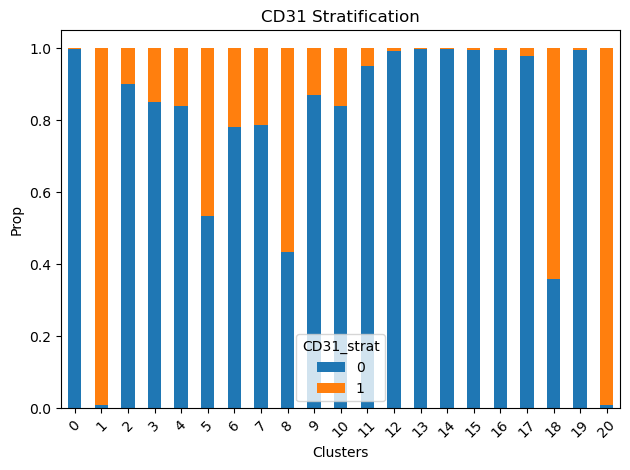

In [92]:
gene_df = sc.get.obs_df(adata, keys=["leiden_clusters", *marker_cols])
plot_strat(gene_df, "CD31")

In [119]:
print(adata.obs.columns)

Index(['CellID', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'Solidity', 'Extent', 'Orientation', 'leiden_clusters',
       'CD8a_gmm_labels', 'CD31_strat', 'CD45_strat', 'CD68_strat',
       'CD4_strat', 'FOXP3_strat', 'CD8a_strat', 'CD45RO_strat', 'CD20_strat',
       'PD-L1_strat', 'CD3e_strat', 'CD163_strat', 'E-cadherin_strat',
       'PD-1_strat', 'Ki67_strat', 'Pan-CK_strat', 'SMA_strat'],
      dtype='object')


In [125]:
met = adata.obs

query_list = [
    [["E-cadherin", "Pan-CK"], "OR"],
    [["E-cadherin", "Pan-CK"], "AND"],
    [["CD31"]],
    [["SMA"]],
    [["CD45"]],
    [["CD68"]],
    [["CD45", "CD68"], "AND"],
    [["CD45", "CD68", "CD163"], "AND"],
    [["CD3e"]],
    [["CD45", "CD3e"], "AND"],
    [["CD8a"]],
    [["CD45", "CD3e", "CD8a"], "AND"],
    [["CD4"]],
    [["CD45", "CD3e", "CD4"], "AND"]
]

for query in query_list:
    print_counts(met, 21, query)
    print("-------------------------------------\n" \
    "-------------------------------------\n" )


Cluster 0: 20 cells marked as positive for ['CD20'] with operator NONE *operator not applicable if marker is a single value
Cluster 1: 9309 cells marked as positive for ['CD20'] with operator NONE *operator not applicable if marker is a single value
Cluster 2: 1305 cells marked as positive for ['CD20'] with operator NONE *operator not applicable if marker is a single value
Cluster 3: 357 cells marked as positive for ['CD20'] with operator NONE *operator not applicable if marker is a single value
Cluster 4: 2417 cells marked as positive for ['CD20'] with operator NONE *operator not applicable if marker is a single value
Cluster 5: 8 cells marked as positive for ['CD20'] with operator NONE *operator not applicable if marker is a single value
Cluster 6: 7312 cells marked as positive for ['CD20'] with operator NONE *operator not applicable if marker is a single value
Cluster 7: 2298 cells marked as positive for ['CD20'] with operator NONE *operator not applicable if marker is a single valu

Manual Cell Thresholding Below


/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_66575/3644594971.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_df.groupby("leiden_clusters")["CD8a_gmm_labels"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

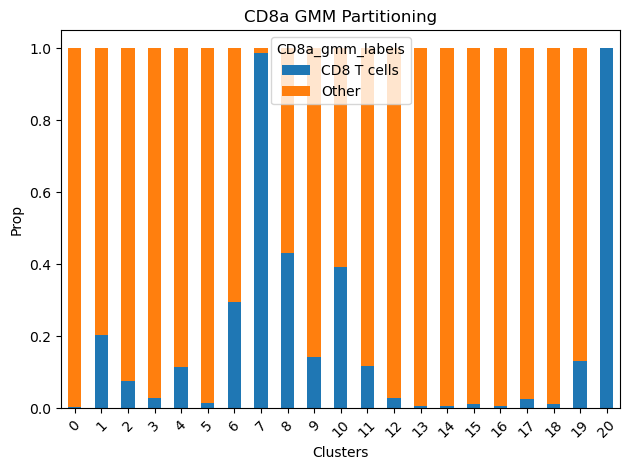

In [59]:
log_cd8_exprs = adata[:, "CD8a"].layers["log1p"].flatten()

gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(log_cd8_exprs.reshape(-1, 1))
# Predict cluster labels
log_cd8a_labels = gmm.predict(log_cd8_exprs.reshape(-1, 1))
# make log_cd8_labels categorical
log_cd8a_labels = np.where(log_cd8a_labels == 1, "CD8 T cells", "Other")
adata.obs["CD8a_gmm_labels"] = log_cd8a_labels

plt.figure(figsize=(10, 6))
gene_df["CD8a_gmm_labels"] = adata.obs["CD8a_gmm_labels"]
gene_df.groupby("leiden_clusters")["CD8a_gmm_labels"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.title("CD8a GMM Partitioning")
plt.xlabel("Clusters")
plt.ylabel("Prop")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# clusters 1 and 15 are shown to possibly be CD8 T cells

# check overlap in cell typing labels and cluster labels

temp = pl.DataFrame({
    "cellID": adata.obs_names,
    "cluster_labs": adata.obs["leiden_clusters"],
    "gmm_labs": adata.obs["CD8a_gmm_labels"]
})

# print total cells thresholded
count1 = temp.filter(((pl.col("cluster_labs").cast(pl.Int32)==1)) | (pl.col("cluster_labs").cast(pl.Int32)==15)).shape[0]
count2 = temp.filter(pl.col("gmm_labs")=="CD8 T cells").shape[0]

print(f"Total cells in clusters 1 and 15: {count1}")
print(f"Total cells by GMM: {count2}")

overlap = temp.filter((((pl.col("cluster_labs").cast(pl.Int32)==1)) | (pl.col("cluster_labs").cast(pl.Int32)==15))
                       & (pl.col("gmm_labs")=="CD8 T cells")).shape[0]

print(f"Overlap of two methods: {overlap}")
print(f"Percent of cells in clusters 1 and 15 that are marked as CD8 T cells: {overlap/count1:.2%}")

Total cells in clusters 1 and 15: 78984
Total cells by GMM: 183675
Overlap of two methods: 74962
Percent of cells in clusters 1 and 15 that are marked as CD8 T cells: 94.91%


/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_66575/2241367654.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_df.groupby("leiden_clusters")["CD3e_labs"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

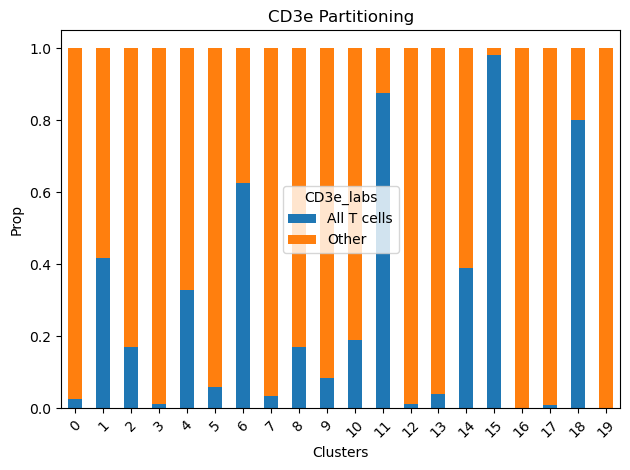

In [22]:
# identify all T cells (using CD3e, a pan-T cell marker)

log_cd3e_exprs = adata[:, "CD3e"].layers["log1p"].flatten()

gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(log_cd3e_exprs.reshape(-1, 1))
# Predict cluster labels
log_cd3e_labels = gmm.predict(log_cd3e_exprs.reshape(-1, 1))
# make log_cd8_labels categorical
log_cd3e_labels = np.where(log_cd3e_labels == 1, "All T cells", "Other")
adata.obs["CD3e_labs"] = log_cd3e_labels

plt.figure(figsize=(10, 6))
gene_df["CD3e_labs"] = adata.obs["CD3e_labs"]
gene_df.groupby("leiden_clusters")["CD3e_labs"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.title("CD3e Partitioning")
plt.xlabel("Clusters")
plt.ylabel("Prop")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [29]:
# clusters 6, 11, 15, and 18 show the most promise as being T cells
# clusters 1 and 14 have slightly less proportion

# check how many of the CD8 T cells identified before are also marked as CD3e+ according to this model


temp = pl.DataFrame({
    "cellID": adata.obs_names,
    "CD8": adata.obs["CD8a_gmm_labels"],
    "CD3": adata.obs["CD3e_labs"]
})

# print total cells thresholded
count1 = temp.filter((pl.col("CD8")=="CD8 T cells")).shape[0]
count2 = temp.filter(pl.col("CD3")=="All T cells").shape[0]

print(f"Total CD8 T cells: {count1}")
print(f"Total T cells: {count2}")

overlap = temp.filter((pl.col("CD8")=="CD8 T cells")
                       & (pl.col("CD3")=="All T cells")).shape[0]

print(f"Proportion of CD8 T cells also exhibiting CD3: {overlap/count1:.2%}")


Total CD8 T cells: 183675
Total T cells: 263642
Proportion of CD8 T cells also exhibiting CD3: 73.78%


/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_66575/3602326862.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_df.groupby("leiden_clusters")["CD20_labs"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

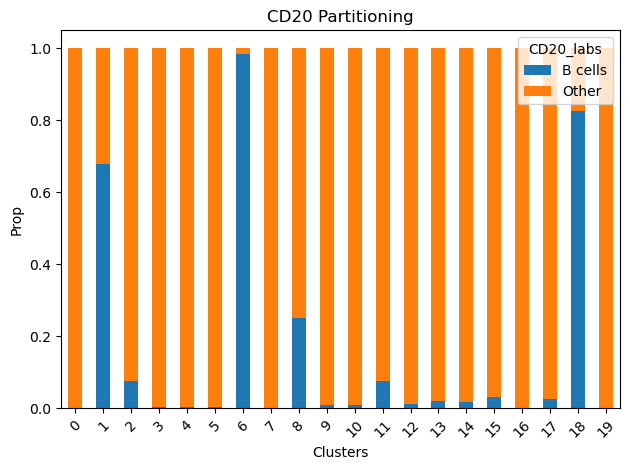

In [30]:
# B cell identification using gmm, CD20

log_cd20_exprs = adata[:, "CD20"].layers["log1p"].flatten()

gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(log_cd20_exprs.reshape(-1, 1))
# Predict cluster labels
log_cd20_labels = gmm.predict(log_cd20_exprs.reshape(-1, 1))
# make log_cd8_labels categorical
log_cd20_labels = np.where(log_cd20_labels == 1, "B cells", "Other")
adata.obs["CD20_labs"] = log_cd20_labels

plt.figure(figsize=(10, 6))
gene_df["CD20_labs"] = adata.obs["CD20_labs"]
gene_df.groupby("leiden_clusters")["CD20_labs"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.title("CD20 Partitioning")
plt.xlabel("Clusters")
plt.ylabel("Prop")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
# seems like pretty clearly clusters 6 and 18 are B cells

# seems like cluster 1 is pretty controversial

# check if there is overlap between identified B and T cells

temp = pl.DataFrame({
    "cellID": adata.obs_names,
    "B cells": adata.obs["CD20_labs"],
    "T cells": adata.obs["CD3e_labs"],
    "clusters": adata.obs["leiden_clusters"]
})

count1 = temp.filter((pl.col("T cells")=="All T cells")).shape[0]
count2 = temp.filter(pl.col("B cells")=="B cells").shape[0]

print(f"Total T cells: {count1}")
print(f"Total B cells: {count2}")

overlap = temp.filter((pl.col("T cells")=="All T cells")
                       & (pl.col("B cells")=="B cells")).shape[0]

print(f"Overlap in B and T cell annotation: {overlap}")

overlap2 = temp.filter((pl.col("T cells")=="All T cells")
                       & (pl.col("B cells")=="B cells") 
                       & (pl.col("clusters").cast(pl.Int32)==1)).shape[0]

print(f"Cells in cluster 1 that are annotated as both B and T cells: {overlap2}")


Total T cells: 263642
Total B cells: 48251
Overlap in B and T cell annotation: 26043
Cells in cluster 1 that are annotated as both B and T cells: 5056


In [33]:
adata.obs

,CellID,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation,leiden_clusters,CD8a_gmm_labels,CD3e_labs,CD20_labs
0,1,588,41.882124,18.370334,0.898673,0.981636,0.864706,1.533761,0,CD8 T cells,All T cells,Other
1,2,740,43.965194,22.187973,0.863312,0.946292,0.764463,-1.530993,1,CD8 T cells,Other,B cells
2,3,193,18.694776,13.708441,0.679931,0.914692,0.756863,-0.904913,0,CD8 T cells,All T cells,Other
3,4,408,23.768887,21.976172,0.380995,0.978417,0.771267,0.603646,5,Other,Other,Other
4,5,1494,74.087383,26.469302,0.934001,0.918254,0.507473,0.967785,5,Other,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
1620370,1620371,497,28.448086,22.773829,0.599279,0.935970,0.806818,1.437491,4,Other,All T cells,B cells
1620371,1620372,221,21.540405,13.837058,0.766389,0.876984,0.619048,1.066740,4,Other,All T cells,B cells
1620372,1620373,394,26.139311,19.355939,0.672066,0.951691,0.721612,1.274071,4,Other,All T cells,B cells
1620373,1620374,339,22.896479,18.906752,0.564037,0.960340,0.770455,1.221391,4,Other,All T cells,B cells
